# Point Cloud Model (LiDAR + Radar)

In [0]:
#--------------------------------------------------------------------------------------------------------------
# !pip install open3d
# !pip install nuscenes-devkit
#--------------------------------------------------------------------------------------------------------------

In [1]:
#--------------------------------------------------------------------------------------------------------------
# importing libraries
#--------------------------------------------------------------------------------------------------------------
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box

import keras
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import open3d as o3d

from keras.models import Model
from keras import layers
from keras.layers import Dense, Dropout, Input

#--------------------------------------------------------------------------------------------------------------
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 100
INIT_LR = 1e-3
BS = 64
#--------------------------------------------------------------------------------------------------------------

Using TensorFlow backend.


In [2]:
#--------------------------------------------------------------------------------------------------------------
datafile = "./drive/My Drive/v1.0-mini/data/Final_Data_2_Changed.csv"
#datafile = "./drive/My Drive/v1.0-mini/data/Final_Sample_Wise_changed.csv"
dataframe = pd.read_csv(datafile)
dataframe.head()
#--------------------------------------------------------------------------------------------------------------

,index,lidar_top,radar_front,radar_front_left,radar_front_right,radar_back_left,radar_back_right,montage_image,bbox_size,num_lidar_pts,num_radar_pts,visibility_token,category_name
0,0,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.621, 0.669, 1.642]",1,0,1,pedestrian
1,1,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.775, 0.769, 1.711]",2,0,2,pedestrian
2,2,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[2.011, 4.633, 1.573]",5,0,3,vehicle_small
3,3,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.752, 0.819, 1.637]",1,0,4,pedestrian
4,4,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.427, 0.359, 0.794]",1,0,4,small_objects


In [0]:
#--------------------------------------------------------------------------------------------------------------
# functions to read point cloud data
#--------------------------------------------------------------------------------------------------------------
def readLidarData(dataframe):
  data = []
  path = "./drive/My Drive/v1.0-mini/"
  for file in dataframe:
    pt = LidarPointCloud.from_file(path+file)
    data.append([np.sum(pt.points[0]), np.sum(pt.points[1]), np.sum(pt.points[2]), np.sum(pt.points[3])])
  print("Lidar Data Finished Loading..")
  return np.array(data)
#--------------------------------------------------------------------------------------------------------------
def readRadarData(dataframe):
  data = []
  path = "./drive/My Drive/v1.0-mini/"
  for file in dataframe:
    pcd = o3d.io.read_point_cloud(path+file)
    downpcd = pcd.voxel_down_sample(voxel_size=0.05)
    temp = downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=4))
    d1 = np.asarray(np.sum(downpcd.normals))

    pt = RadarPointCloud.from_file(path+file)

    data.append([np.sum(pt.points), d1])
  print("Radar Data Finished Loading..")
  return np.array(data)
#--------------------------------------------------------------------------------------------------------------
def readAllPointClout(dataframe):
  data = readLidarData(dataframe['lidar_top'])
  #print("Lidar Data Shape:", data.shape)

  rdata1 = readRadarData(dataframe['radar_front'])
  #print("Radar Data 1 Shape:", rdata1.shape)
  rdata2 = readRadarData(dataframe['radar_front_left'])
  #print("Radar Data 2 Shape:", rdata2.shape)
  rdata3 = readRadarData(dataframe['radar_front_right'])
  #print("Radar Data 3 Shape:", rdata3.shape)
  rdata4 = readRadarData(dataframe['radar_back_left'])
  #print("Radar Data 4 Shape:", rdata4.shape)
  rdata5 = readRadarData(dataframe['radar_back_right'])
  #print("Radar Data 5 Shape:", rdata5.shape)

  finaldata = np.column_stack((data, rdata1, rdata2, rdata3, rdata4, rdata5))
  #print("Final Data Shape", finaldata.shape)
  return np.array(finaldata)
#--------------------------------------------------------------------------------------------------------------

In [0]:
#--------------------------------------------------------------------------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#--------------------------------------------------------------------------------------------------------------
# Data Preprocessing
#--------------------------------------------------------------------------------------------------------------
# Encoding Labels
labels = dataframe['category_name']
le = LabelEncoder()
le.fit(labels)
labels_encoded = le.transform(labels)
le.classes_
len(labels_encoded)
#--------------------------------------------------------------------------------------------------------------
# Creating train/test split
X_train, X_test, y_train, y_test = train_test_split(dataframe, labels_encoded, test_size=0.20, random_state=20)
#--------------------------------------------------------------------------------------------------------------

In [0]:
#--------------------------------------------------------------------------------------------------------------
# Reading Lidar PointCloud Data
print("Reading Training Point Clouds..")
pc_train = readAllPointClout(X_train)
print("Reading Testing Point Clouds..")
pc_test  = readAllPointClout(X_test)

#pc_train.shape
#--------------------------------------------------------------------------------------------------------------

In [0]:
#--------------------------------------------------------------------------------------------------------------
# PointCloud Model Architecture
#-------------------------------------------------------------------------------------------------------------- 

def create_PC(dim, classess):
	inputshape = dim
	inputs = Input(shape=inputshape)
	
	x = Dense(1024, name="pc_dense_1024")(inputs)
	x = Dropout(0.5, name="pc_drop1024")(x)
 
	for size in [512, 256, 128, 64, 32, 16]:	
		x	=	Dense(size, activation = "relu", name="pc_dense"+str(size))(x)
		x = Dropout(0.5, name="pc_drop"+str(size))(x)
		x = layers.BatchNormalization(name="pc_"+str(size))(x)
	
	x = Dense(8, name="pc_dense8")(x)
	x = layers.BatchNormalization(name="pc_dense8final")(x)
	x = Dense(classess, activation="softmax", name="pc_output5")(x)
	
	# return our model
	return keras.Model(inputs, x)
#--------------------------------------------------------------------------------------------------------------

In [0]:
#--------------------------------------------------------------------------------------------------------------
# Creating the PointCloud Model
#--------------------------------------------------------------------------------------------------------------
model = create_PC((14,), 4)
keras.utils.plot_model(model, show_shapes=True)
model.summary()
#--------------------------------------------------------------------------------------------------------------

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 14)                0         
_________________________________________________________________
pc_dense_1024 (Dense)        (None, 1024)              15360     
_________________________________________________________________
pc_drop1024 (Dropout)        (None, 1024)              0         
_________________________________________________________________
pc_dense512 (Dense)          (None, 512)               524800    
_________________________________________________________________
pc_drop512 (Dropout)         (None, 512)               0         
_________________________________________________________________
pc_512 (BatchNormalization)  (None, 512)               2048      
_________________________________________________________________
pc_dense256 (Dense)          (None, 256)               1313

In [0]:
#--------------------------------------------------------------------------------------------------------------
# Training Model
#--------------------------------------------------------------------------------------------------------------
callbacks = [
    #keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(INIT_LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
Hist = model.fit(
    pc_train, y_train, epochs = EPOCHS, validation_data = (pc_test, y_test),
     shuffle="true", batch_size=BS
)
#--------------------------------------------------------------------------------------------------------------

Train on 14830 samples, validate on 3708 samples
Epoch 1/100
14830/14830 [==============================] - 7s 461us/step - loss: 1.4196 - accuracy: 0.3554 - val_loss: 1.2595 - val_accuracy: 0.4455
Epoch 2/100
14830/14830 [==============================] - 5s 367us/step - loss: 1.2604 - accuracy: 0.4376 - val_loss: 1.2378 - val_accuracy: 0.4455
Epoch 3/100
14830/14830 [==============================] - 5s 359us/step - loss: 1.2312 - accuracy: 0.4486 - val_loss: 1.2320 - val_accuracy: 0.4455
Epoch 4/100
14830/14830 [==============================] - 5s 357us/step - loss: 1.2125 - accuracy: 0.4575 - val_loss: 1.2314 - val_accuracy: 0.4455
Epoch 5/100
14830/14830 [==============================] - 5s 366us/step - loss: 1.1937 - accuracy: 0.4691 - val_loss: 1.2179 - val_accuracy: 0.4517
Epoch 6/100
14830/14830 [==============================] - 6s 379us/step - loss: 1.1818 - accuracy: 0.4800 - val_loss: 1.2479 - val_accuracy: 0.4455
Epoch 7/100
14830/14830 [==============================] 

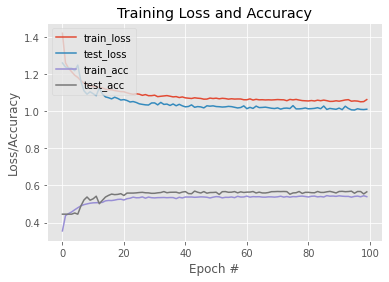

In [0]:
#--------------------------------------------------------------------------------------------------------------
# Plotting Training Loss and Accuracy
#--------------------------------------------------------------------------------------------------------------
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), Hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), Hist.history["val_loss"], label="test_loss")
plt.plot(np.arange(0, N), Hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), Hist.history["val_accuracy"], label="test_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()
#--------------------------------------------------------------------------------------------------------------

In [0]:
#--------------------------------------------------------------------------------------------------------------
# Saving Model for later use
#--------------------------------------------------------------------------------------------------------------
model.save("./drive/My Drive/v1.0-mini/model/pc_model.h5")  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = keras.models.load_model("./drive/My Drive/Amit/pc_model.h5")
#--------------------------------------------------------------------------------------------------------------